In [164]:
import sys
sys.path.insert(0, '..')

In [165]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

import jax.tree_util as jtu
from glob import glob

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [166]:
extra_bad = None
#extra_bad = np.isnan(np.zeros((64, 64)).at[35,60].set(np.nan))

#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)


In [167]:
wid = 64
oversample = 4

nwavels = 10#6
npoly=3#2

n_zernikes = 12

optics = NICMOSOptics(1024, wid, oversample, n_zernikes = n_zernikes)

detector = NICMOSDetector(oversample, wid)


files = glob("../data/MAST_2025-07-15T10_28_53.801Z/HST/*_cal.fits")
files.sort()

files = files[:2]



exposures_single = [exposure_from_file(file, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=None) for file in files]



/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_24677/3969465011.py:21: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  exposures_single = [exposure_from_file(file, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=None) for file in files]
/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_24677/3969465011.py:21: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  exposures_single = [exposure_from_file(file, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=None) for file in files]


In [168]:
for e in exposures_single:
    print(e.mjd)#*86400)
    print(e.target)
    print(e.filter)

52531.07692254
P330-E
F160W
52531.07902902
P330-E
F160W


In [169]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,

    "softening": 2.,#0.1,
    "bias": {},
    "jitter": {},
    #"displacement": 1.#1e5#{}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_zernikes)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([8., 8.])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. 
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample


model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
#model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [170]:
params

ModelParams(
  params={
    'positions': {'n8hl01tlq': f32[2], 'n8hl01tnq': f32[2]},
    'spectrum': {'P330-E_F160W': f32[3]},
    'aberrations': {'n8hl01tlq': f32[12], 'n8hl01tnq': f32[12]},
    'cold_mask_shift': {'52531': f32[2]},
    'cold_mask_rot': {'global': -45.0},
    'cold_mask_scale': {'F160W': f32[2]},
    'cold_mask_shear': {'F160W': f32[2]},
    'primary_scale': {'F160W': f32[2]},
    'primary_rot': {'F160W': 45.0},
    'primary_shear': {'F160W': f32[2]},
    'outer_radius': 1.146,
    'secondary_radius': 0.44639999999999996,
    'spider_width': 0.0924,
    'scale': 0.0432,
    'softening': 2.0,
    'bias': {'n8hl01tlq': 0.0, 'n8hl01tnq': 0.0},
    'jitter': {'n8hl01tlq': 0.6511627906976745, 'n8hl01tnq': 0.6511627906976745}
  }
)

In [171]:
#plot_comparison(model_single, params, exposures_single)

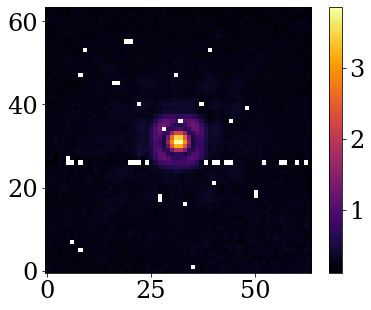

In [172]:
plt.imshow(exposures_single[0].err)
plt.colorbar()

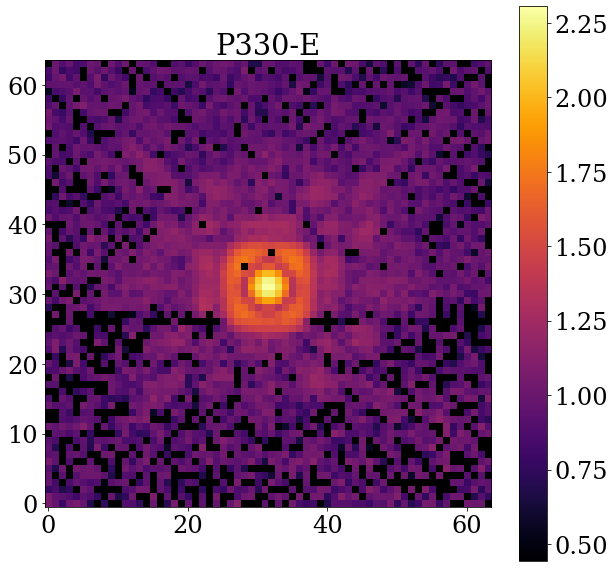

In [173]:
cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)
plt.figure(figsize=(10,10))
plt.imshow(exposures_single[0].data**0.125, cmap=cmap)
plt.title(exposures_single[0].target)
plt.colorbar()


In [174]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

base_rmsprop = lambda vals: optax.rmsprop(vals)#, nesterov=True, momentum=0.6)
optr = lambda lr, start, *schedule: base_rmsprop(scheduler(lr, start, *schedule))




def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-2

things = {
    "positions": opt(g*5, 0),
    "spectrum": opt(g*8, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*300, 30),
    #"cold_mask_rot": opt(g*10, 100),
    "bias": opt(g*3, 20),
    #"aberrations": opt(g*0.15,300),#, (80, 2)),#, (150, g*0.2)),
    #"aberrations": opta(2, 50),
    "aberrations": opta(2, 50),
    #"aberrations": optl(2,50),
    #"displacement": opt(g*30, 150),

    #"cold_mask_scale": opt(g*100, 250),
    #"cold_mask_shear": opt(g*100, 250),
    #"primary_scale": opt(g*100, 300),
    #"primary_shear": opt(g*100, 300),
}


groups = list(things.keys())

In [175]:
losses, models = optimise(params, model_single, exposures_single, things, 300)

Calculating Fishers


  0%|          | 0/2 [00:00<?, ?it/s]

ModelParams(
  params={
    'positions': {'n8hl01tlq': f32[2], 'n8hl01tnq': f32[2]},
    'spectrum': {'P330-E_F160W': f32[3]},
    'aberrations': {'n8hl01tlq': f32[12], 'n8hl01tnq': f32[12]},
    'cold_mask_shift': {'52531': f32[2]},
    'cold_mask_rot': {'global': -45.0},
    'cold_mask_scale': {'F160W': f32[2]},
    'cold_mask_shear': {'F160W': f32[2]},
    'primary_scale': {'F160W': f32[2]},
    'primary_rot': {'F160W': 45.0},
    'primary_shear': {'F160W': f32[2]},
    'outer_radius': 1.146,
    'secondary_radius': 0.44639999999999996,
    'spider_width': 0.0924,
    'scale': 0.0432,
    'softening': 2.0,
    'bias': {'n8hl01tlq': 0.0, 'n8hl01tnq': 0.0},
    'jitter': {'n8hl01tlq': 0.6511627906976745, 'n8hl01tnq': 0.6511627906976745}
  }
)
Fitting Model


  0%|          | 0/300 [00:00<?, ?it/s]

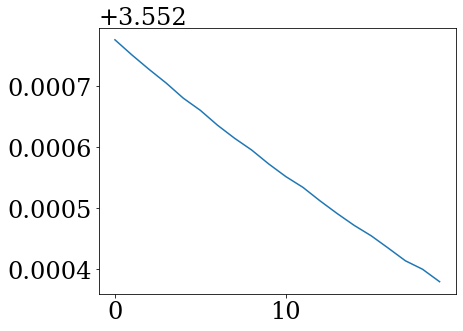

In [176]:
plt.plot(np.asarray(losses[-20:])/(len(exposures_single)*wid**2))

5


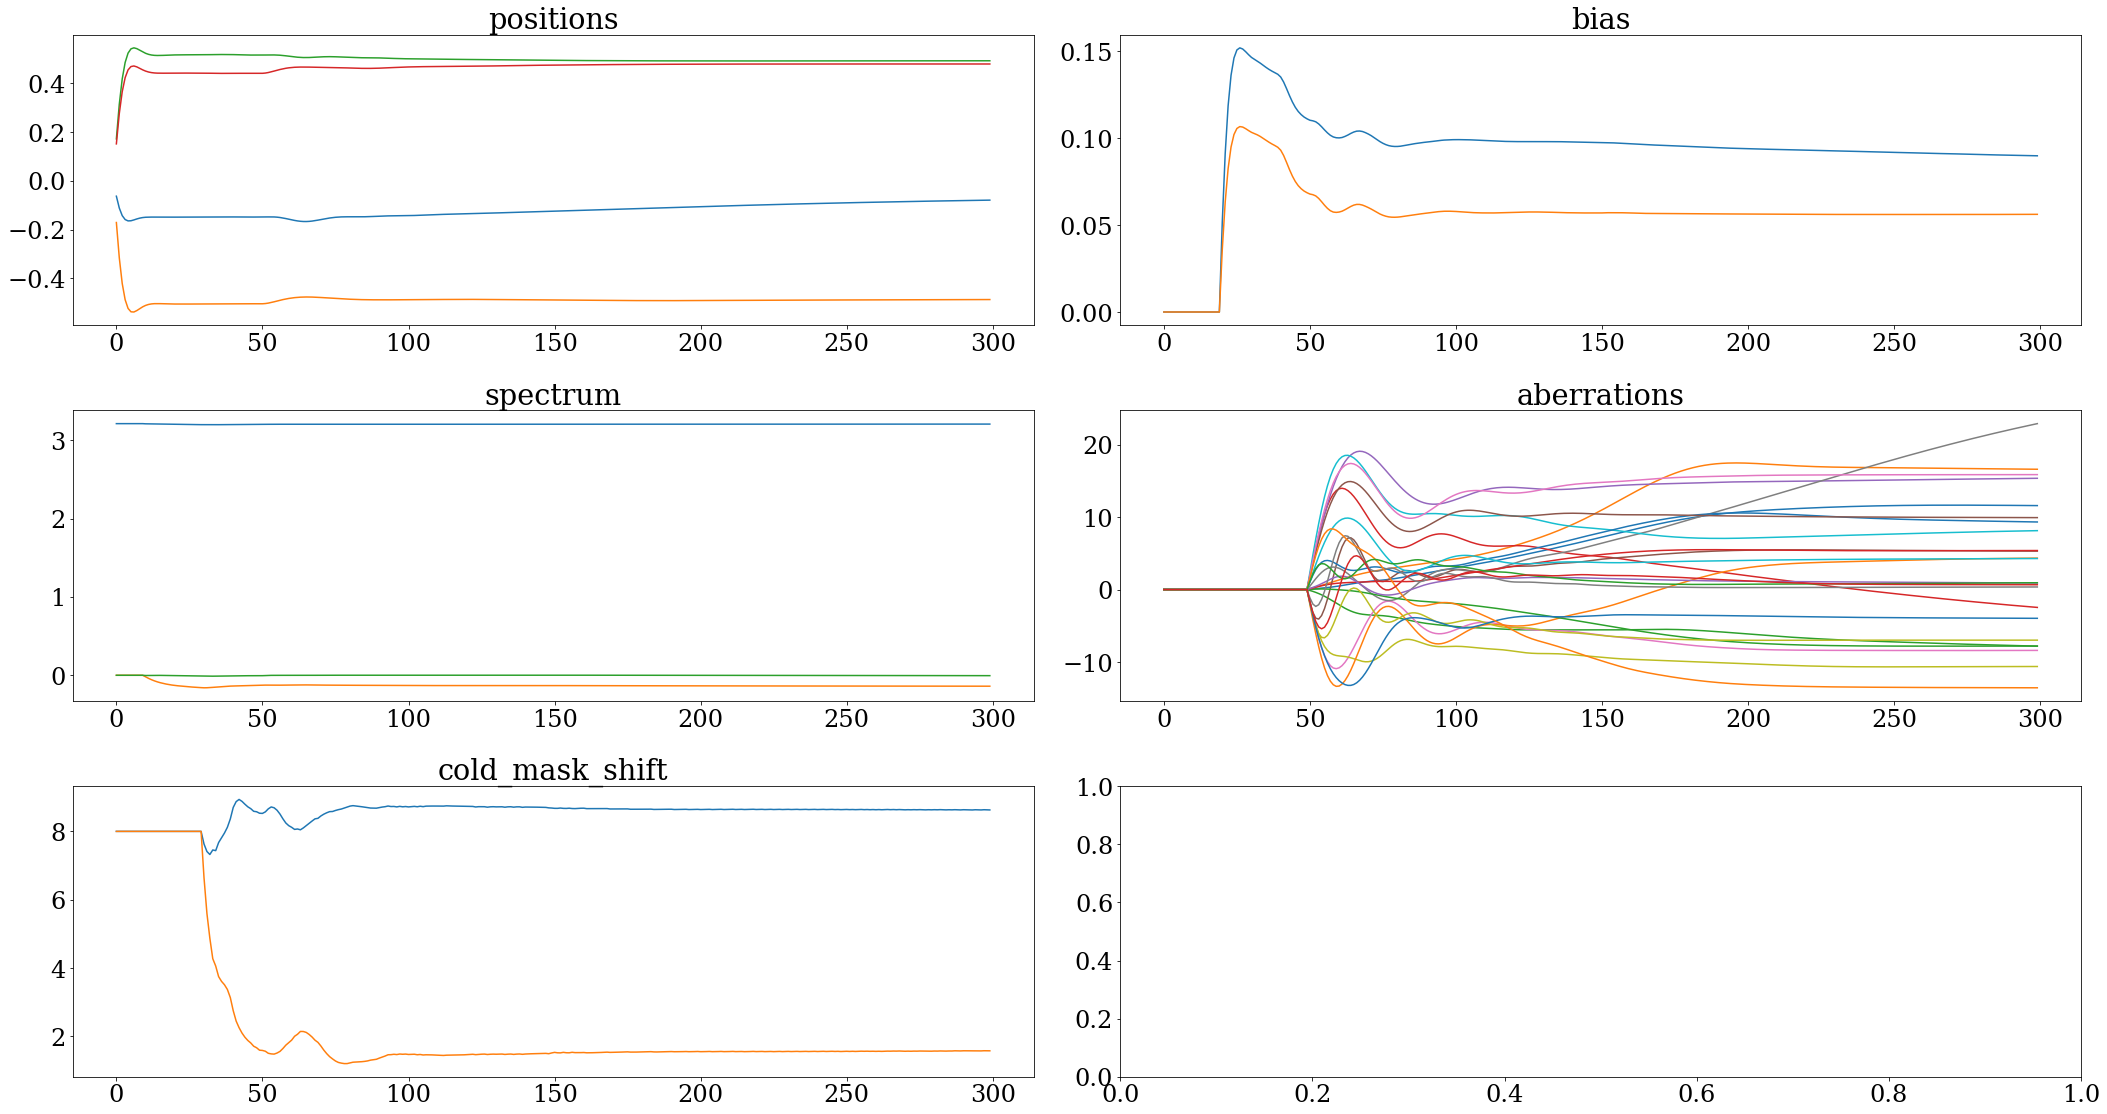

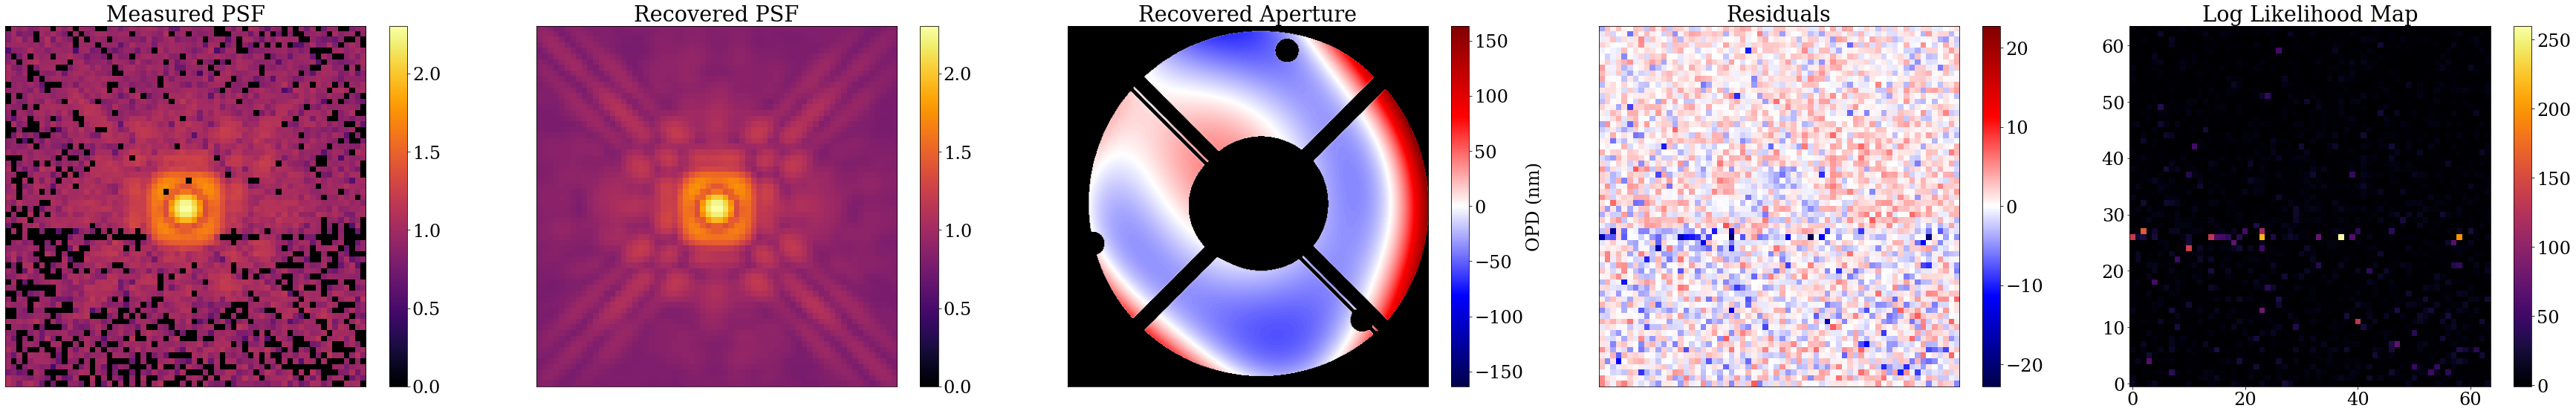

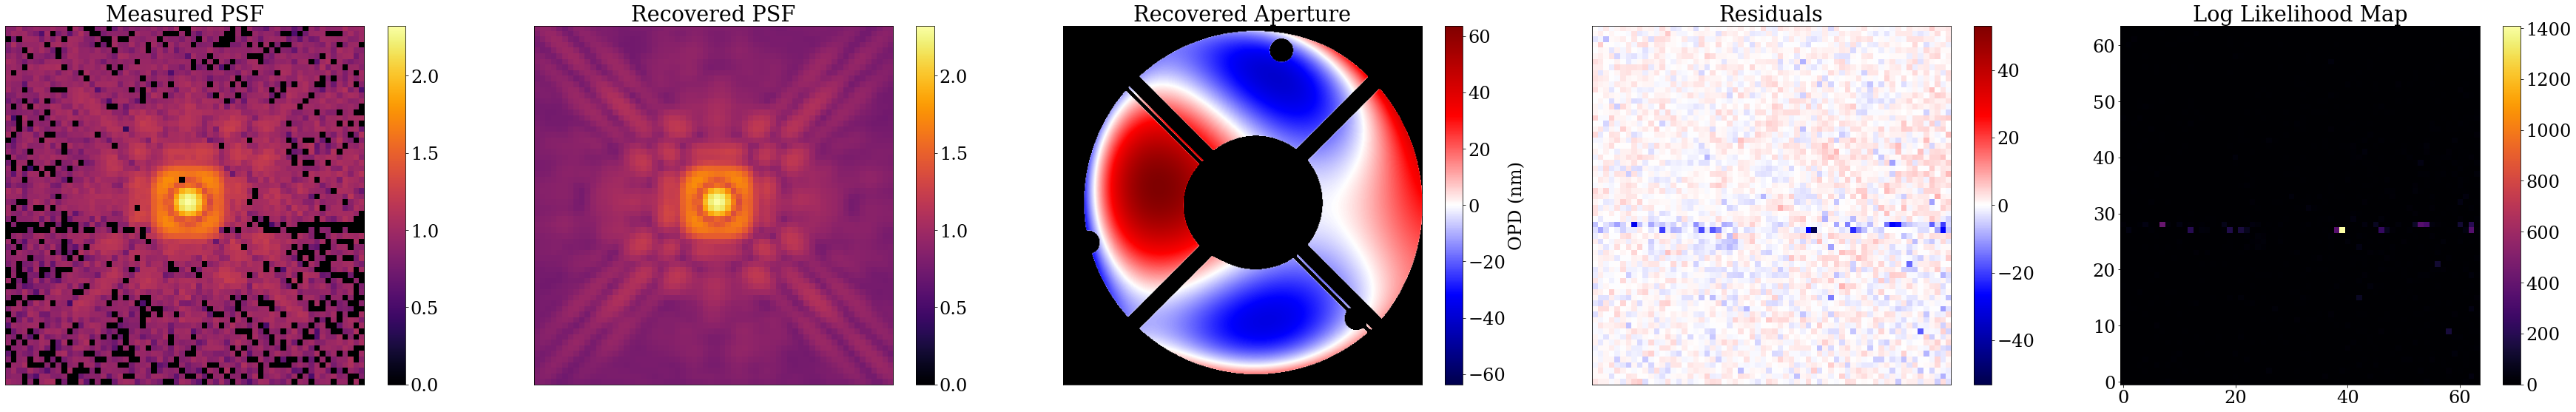

In [177]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [178]:
models[-1].inject(model_single)

NICMOSModel(
  params={
    'aberrations': {'n8hl01tlq': f32[12], 'n8hl01tnq': f32[12]},
    'bias': {'n8hl01tlq': f32[], 'n8hl01tnq': f32[]},
    'cold_mask_rot': {'global': f32[]},
    'cold_mask_scale': {'F160W': f32[2]},
    'cold_mask_shear': {'F160W': f32[2]},
    'cold_mask_shift': {'52531': f32[2]},
    'jitter': {'n8hl01tlq': f32[], 'n8hl01tnq': f32[]},
    'outer_radius': f32[],
    'positions': {'n8hl01tlq': f32[2], 'n8hl01tnq': f32[2]},
    'primary_rot': {'F160W': f32[]},
    'primary_scale': {'F160W': f32[2]},
    'primary_shear': {'F160W': f32[2]},
    'scale': f32[],
    'secondary_radius': f32[],
    'softening': f32[],
    'spectrum': {'P330-E_F160W': f32[3]},
    'spider_width': f32[]
  },
  filters={'F160W': f32[238,2]},
  optics=NICMOSOptics(
    wf_npixels=1024,
    diameter=f32[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=True,
        transformation=CoordTransform(
          translation=None, rotation=f32[], compression=Non

In [179]:
fsh = calc_fishers(models[-1].inject(model_single), exposures_single, ["cold_mask_shift"], recalculate=True, save=False)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [180]:
np.linalg.inv(fsh["n8hl01tlq"]["cold_mask_shift"])

Array([[ 0.00150862, -0.00778018],
       [-0.00778018, -0.01770747]], dtype=float32)

In [181]:
defocuses = [x[0] for x in models[-1].params["aberrations"].values()]
errs = [1/x['defocus']/20 for x in fsh.values()]
mjds = [exp.mjd for exp in exposures_single]
mjds= [(x - mjds[0])*24*60 for x in mjds]


KeyError: 'defocus'

In [ ]:
fsh = calc_fishers(models[-1].inject(model_single), exposures_single, ["cold_mask_shift"], recalculate=True, save=False)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
fsh

{'n43ca5fjq': {'cold_mask_shift': Array([[390.8453 , 140.86757],
         [140.86752, 416.00952]], dtype=float32)},
 'n43ca5fkq': {'cold_mask_shift': Array([[152.32484, 105.43479],
         [105.43475, 345.59708]], dtype=float32)},
 'n43ca5flq': {'cold_mask_shift': Array([[345.77246 ,  55.504807],
         [ 55.50482 , 300.86816 ]], dtype=float32)},
 'n43ca5fmq': {'cold_mask_shift': Array([[1238.8579 ,   44.38602],
         [  44.38599, 1308.0029 ]], dtype=float32)},
 'n43ca5feq': {'cold_mask_shift': Array([[2689.8403 ,  561.36896],
         [ 561.3691 , 2995.826  ]], dtype=float32)},
 'n43ca5ffq': {'cold_mask_shift': Array([[2504.4548,  871.225 ],
         [ 871.225 , 2532.2686]], dtype=float32)},
 'n43ca5fgq': {'cold_mask_shift': Array([[  14.643265,  410.93805 ],
         [ 410.93787 , -500.36264 ]], dtype=float32)},
 'n43ca5fhq': {'cold_mask_shift': Array([[1289.0402 ,  509.19507],
         [ 509.19507, 1018.38055]], dtype=float32)}}

In [ ]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F170M", nwavels=nwavels)

#HD201592_F110M

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("spectrum.LHS1846_F170M")).weights))#), yerr = spectrum_err)


KeyError: 'LHS1846_F170M'

<Figure size 720x720 with 0 Axes>

In [ ]:
bad = np.ones((wid, wid))

In [ ]:
for i in range(8):
    pst = posterior(models[-1].inject(model_single),exposures_single[0],return_im=True)
    idx = np.unravel_index(np.nanargmax(pst*bad), pst.shape)
    bad = bad.at[idx].set(np.nan)


In [ ]:
extra_bad = np.isnan(bad)

In [ ]:
idx

(Array(68, dtype=int32), Array(67, dtype=int32))

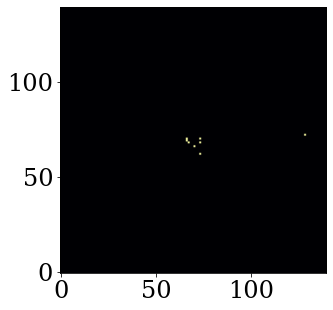

In [ ]:
plt.imshow(extra_bad)

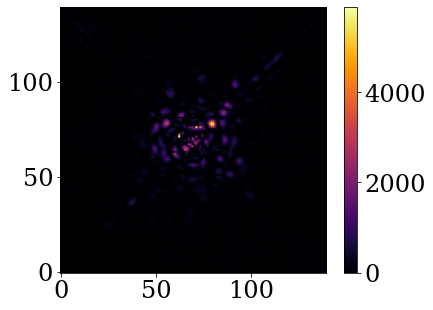

In [ ]:
plt.imshow(pst*(1-extra_bad))
plt.colorbar()

In [ ]:
jsp.stats.norm.logpdf(0,0,0.1)

Array(1.3836465, dtype=float32, weak_type=True)